## Importing required libraries

In [2]:
import cv2
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import f1_score
import torchvision.transforms as transforms
from torchvision import models as resnet_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(str(device) + ' is selected !')

cuda is selected !


## Network Architecture

In [3]:
class DecoderBottleneckLayer(nn.Module):
    def __init__(self, in_channels, n_filters, use_transpose=True):
        super(DecoderBottleneckLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nn.LeakyReLU()

        if use_transpose:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1
                ),
                nn.BatchNorm2d(in_channels // 4),
                nn.LeakyReLU()
            )
        else:
            self.up = nn.Upsample(scale_factor=2, align_corners=True, mode="bilinear")

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.up(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x

class FFBlock(nn.Module):
    def __init__(self, channels):
        super(FFBlock, self).__init__()

        self.conv3 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1)

        self.relu3 = nn.LeakyReLU()
        self.relu1 = nn.LeakyReLU()

    def forward(self, x):
        x3 = self.conv3(x)
        x3 = self.relu3(x3)
        x1 = self.conv1(x)
        x1 = self.relu1(x1)
        out = x3 + x1

        return out

class SEBlock(nn.Module):
    def __init__(self, channel, r=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // r, bias=False),
            nn.LeakyReLU(),
            nn.Linear(channel // r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        ## Squeeze operation
        y = self.avg_pool(x).view(b, c)
        ## Excitation operation
        y = self.fc(y).view(b, c, 1, 1)
        ## Fusion operation
        y = torch.mul(x, y)
        return y

class PDFBlock(nn.Module):
    def __init__(self,in_channels, out_channels_list, kernel_size_list, dilation_list):
        super(PDFBlock, self).__init__()
        self.conv_num = len(out_channels_list)
        assert(self.conv_num == 4)
        assert(self.conv_num == len(kernel_size_list) and self.conv_num == len(dilation_list))
        pad0 = int((kernel_size_list[0] - 1) / 2 * dilation_list[0])
        pad1 = int((kernel_size_list[1] - 1) / 2 * dilation_list[1])
        pad2 = int((kernel_size_list[2] - 1) / 2 * dilation_list[2])
        pad3 = int((kernel_size_list[3] - 1) / 2 * dilation_list[3])
        self.conv_1 = nn.Conv2d(in_channels, out_channels_list[0], kernel_size = kernel_size_list[0], dilation = dilation_list[0], padding = pad0 )
        self.conv_2 = nn.Conv2d(in_channels, out_channels_list[1], kernel_size = kernel_size_list[1], dilation = dilation_list[1], padding = pad1 )
        self.conv_3 = nn.Conv2d(in_channels, out_channels_list[2], kernel_size = kernel_size_list[2], dilation = dilation_list[2], padding = pad2 )
        self.conv_4 = nn.Conv2d(in_channels, out_channels_list[3], kernel_size = kernel_size_list[3], dilation = dilation_list[3], padding = pad3 )

        out_channels  = out_channels_list[0] + out_channels_list[1] + out_channels_list[2] + out_channels_list[3]
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU())

    def forward(self, x):
        x1 = self.conv_1(x)
        x2 = self.conv_2(x)
        x3 = self.conv_3(x)
        x4 = self.conv_4(x)

        y  = torch.cat([x1, x2, x3, x4], dim=1)
        y  = self.conv_1x1(y)
        return y
    
class MET_Net(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(MET_Net, self).__init__()

        transformer = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_distilled_patch16_224', pretrained=True)
        resnet = resnet_model.resnet18(pretrained=True)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu

        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.patch_embed = transformer.patch_embed
        self.transformers = nn.ModuleList( [transformer.blocks[i] for i in range(12)] )

        self.conv_seq_img = nn.Conv2d(in_channels=192, out_channels=512, kernel_size=1, padding=0)
        self.se = SEBlock(channel=1024)
        self.conv2d = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, padding=0)

        self.FFBlock1 = FFBlock(channels=64)
        self.FFBlock2 = FFBlock(channels=128)
        self.FFBlock3 = FFBlock(channels=256)

        self.FFB1 = nn.ModuleList([self.FFBlock1 for i in range(6)])
        self.FFB2 = nn.ModuleList([self.FFBlock2 for i in range(4)])
        self.FFB3 = nn.ModuleList([self.FFBlock3 for i in range(2)])

        filters = [64, 128, 256, 512]
        
        self.decoder4 = DecoderBottleneckLayer(filters[3], filters[2])
        self.decoder3 = DecoderBottleneckLayer(filters[2], filters[1])
        self.decoder2 = DecoderBottleneckLayer(filters[1], filters[0])
        self.decoder1 = DecoderBottleneckLayer(filters[0], filters[0])

        self.final_conv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.final_relu1 = nn.LeakyReLU()
        self.final_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.final_relu2 = nn.LeakyReLU()
        self.final_conv3 = nn.Conv2d(32, n_classes, 3, padding=1)

    def forward(self, x):
        b, c, h, w = x.shape

        e0 = self.firstconv(x)
        e0 = self.firstbn(e0)
        e0 = self.firstrelu(e0)

        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        feature_cnn = self.encoder4(e3)

        emb = self.patch_embed(x)
        for i in range(12):
            emb = self.transformers[i](emb)

        feature_tf = emb.permute(0, 2, 1)
        feature_tf = feature_tf.view(b, 192, 14, 14)
        feature_tf = self.conv_seq_img(feature_tf)

        feature_cat = torch.cat((feature_cnn, feature_tf), dim=1)
        feature_att = self.se(feature_cat)
        feature_out = self.conv2d(feature_att)

        for i in range(2):
            e3 = self.FFB3[i](e3)
        for i in range(4):
            e2 = self.FFB2[i](e2)
        for i in range(6):
            e1 = self.FFB1[i](e1)

        d4 = self.decoder4(feature_out) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1

        out1 = self.final_conv1(d2)
        out1 = self.final_relu1(out1)
        
        out = self.final_conv2(out1)
        out = self.final_relu2(out)
        out = self.final_conv3(out)

        return out

## Load & Visualize Model

In [4]:
## Please download pretrained weight: https://drive.google.com/file/d/1eeSjO2SN1YccDH3IHNFd7qzCqxypPeMZ/

model = MET_Net().cuda()

model = model.to(device)

model.load_state_dict(torch.load('Fold_1_Model.pth', map_location=device))

model.eval()

summary(model, (3, 224, 224))

Using cache found in C:\Users\Ahmed/.cache\torch\hub\facebookresearch_deit_main


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          36,864
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          36,864
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
       BasicBlock-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,864
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
           Conv2d-14         [-1, 64, 1

# Load Original Image & Mask

In [5]:
# Define the transformations for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the original image and mask
data_path = 'test_imgs/'

img_path = data_path + 'img_004340.png'
msk_path = data_path + 'msk_004340.png'

original_img = Image.open(img_path)
mask_img = Image.open(msk_path)

# Apply transformations to the original image
input_img = transform(original_img)
input_img = input_img.to(device)

# Input Shape
print('Input Shape:', input_img.shape)

Input Shape: torch.Size([3, 224, 224])


# Make Predictions using  model

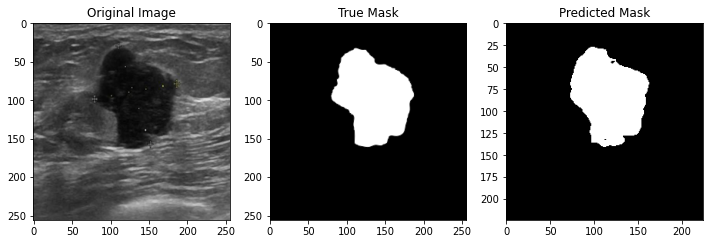

In [6]:
with torch.no_grad():
    input_img = input_img.unsqueeze(0)  # Add batch dimension (1, C, H, W)
    predicted_mask = model(input_img)

# Convert the predicted mask back to an image
predicted_mask = torch.sigmoid(predicted_mask)  # Apply sigmoid if needed
predicted_mask = (predicted_mask > 0.5).float()  # Convert to binary mask
predicted_mask = predicted_mask.squeeze(0)  # Remove batch dimension
predicted_mask = transforms.ToPILImage()(predicted_mask)

# Display the original image, mask, and predicted mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_img)

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(mask_img, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')

plt.show()